# Window optimizer vs Drift correction

In [1]:
import sys, os, pprint, time
sys.path.append(os.path.abspath('../'))
import argparse, logging, sys
import ptp.reader
import ptp.ls
import ptp.metrics
import ptp.frequency
import ptp.pktselection
import ptp.window
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import logging
logging.basicConfig(level=logging.WARNING)
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
#filename = "serial-20200114-102612.json" # ocxo, 2 RRUs, no FH traffic
#filename = "serial-20200116-215655.json" # ocxo, 2 RRUs, FH traffic
filename = "serial-20200117-081236.json" # xo, 2 RRUs, FH traffic, daytime


reader = ptp.reader.Reader("../data/" + filename)
reader.run()
print("Dataset info:")
pprint.pprint(reader.metadata)

Dataset info:
{'fh_traffic': {'bitrate': {'dl': 837120000.0, 'ul': 837120000.0},
                'fs': 7680000.0,
                'iq_size': 24,
                'n_rru_dl': 2,
                'n_rru_ul': 2,
                'n_spf': 64,
                'type': 'inline'},
 'hops': 4,
 'n_rru_ptp': 2,
 'oscillator': 'xo',
 'start_time': '2020-01-17 08:12:35',
 'sync_period': 0.25}


In [3]:
def process_all():
    """Optimize window length and process all packet selection algorithms

    """
    # Optimize window lenght
    T_ns      = reader.metadata["sync_period"]*1e9
    window_op = ptp.window.Optimizer(reader.data, T_ns)
    window_op.process('all', file=filename, force=True)
    
    est_op    = window_op.est_op
    print("Tunned window lengths:")
    
    for i in est_op:
        print("%20s: %d" %(i, est_op[i]["N_best"]))
    
    # Packet Selection algorithms    
    # Sample-average
    N_moveavg = est_op["sample-average"]["N_best"]
    pkts = ptp.pktselection.PktSelection(N_moveavg, reader.data)
    pkts.process("avg-normal")

    # Exponentially weighted moving average
    N_ewma = est_op["sample-ewma"]["N_best"]
    pkts.set_window_len(N_ewma)
    pkts.process("ewma")

    # Sample-median
    N_median = est_op["sample-median"]["N_best"]
    pkts.set_window_len(N_median)
    pkts.process("median")

    # Sample-minimum
    N_min = est_op["sample-min"]["N_best"]
    pkts.set_window_len(N_min)
    pkts.process("min")

    # Sample-mode
    N_mode = est_op["sample-mode"]["N_best"]
    pkts.set_window_len(N_mode)
    pkts.process("mode")

    # Sample-maximum
    N_max = est_op["sample-max"]["N_best"]
    pkts.set_window_len(N_max)
    pkts.process("max")

## Delay Statistics

In [4]:
analyser = ptp.metrics.Analyser(reader.data)
analyser.delay_asymmetry()


Delay asymmetry analysis:

Metric 	      m-to-s	      s-to-m	   asymmetry
Average	 21059.59 ns	 21841.15 ns	  -390.78 ns
Minimum	 19871.00 ns	 19976.00 ns	   -52.50 ns
Maximum	 22302.00 ns	 23194.00 ns	  -446.00 ns
Median	 21194.00 ns	 22030.00 ns	  -418.00 ns


-390.77640361688367

## Window optimizer
### Drift Optimizer #1

Process with delta 256
Tunned window lengths:
                  ls: 128
      sample-average: 16
         sample-ewma: 16
       sample-median: 32
          sample-min: 64
          sample-max: 16
         sample-mode: 16

Time offset estimation error statistics:

x_est                 Mean: -390.795 ns  Sdev:  389.033 ns  RMS:   551.424 ns
x_pkts_avg_normal     Mean: -389.545 ns  Sdev:  133.604 ns  RMS:   411.820 ns
x_pkts_ewma           Mean: -388.266 ns  Sdev:  126.397 ns  RMS:   408.322 ns
x_pkts_median         Mean: -416.013 ns  Sdev:  140.516 ns  RMS:   439.103 ns
x_pkts_min            Mean: -155.687 ns  Sdev:  220.107 ns  RMS:   269.603 ns
x_pkts_max            Mean: -405.160 ns  Sdev:  114.214 ns  RMS:   420.950 ns
x_pkts_mode           Mean: -366.544 ns  Sdev:  338.267 ns  RMS:   498.777 ns


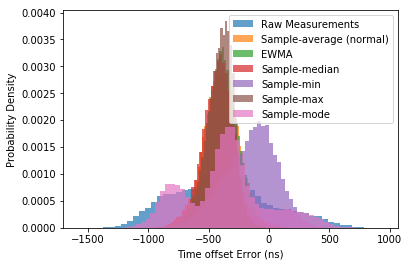

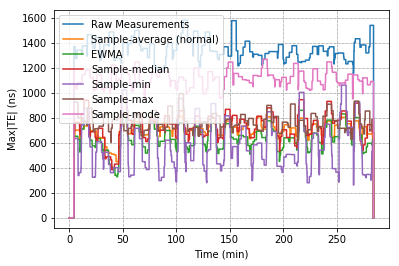

In [5]:
freq_estimator = ptp.frequency.Estimator(reader.data, delta=64)
freq_estimator.set_truth(delta=64)

# Optimize window w.r.t to "true" y
freq_estimator.optimize_to_y()
freq_estimator.process()
freq_estimator.estimate_drift()

print("Process with delta {:d}".format(freq_estimator.delta))

# Optimize window length and run all packet selection algorithms
process_all()

# PTP analyser
analyser.toffset_err_stats()
analyser.plot_toffset_err_hist(save=False)
analyser.plot_max_te(save=False, window_len = 1000)

### Drift Optimizer #2

Process with delta 4
Tunned window lengths:
                  ls: 128
      sample-average: 128
         sample-ewma: 32
       sample-median: 32
          sample-min: 1024
          sample-max: 256
         sample-mode: 2048

Time offset estimation error statistics:

x_est                 Mean: -390.795 ns  Sdev:  389.033 ns  RMS:   551.424 ns
x_pkts_avg_normal     Mean: -391.154 ns  Sdev:  261.386 ns  RMS:   470.451 ns
x_pkts_ewma           Mean: -390.972 ns  Sdev:  261.291 ns  RMS:   470.247 ns
x_pkts_median         Mean: -436.153 ns  Sdev:  269.688 ns  RMS:   512.797 ns
x_pkts_min            Mean:   65.168 ns  Sdev:  272.837 ns  RMS:   280.511 ns
x_pkts_max            Mean: -535.209 ns  Sdev:  274.713 ns  RMS:   601.595 ns
x_pkts_mode           Mean: -462.211 ns  Sdev:  288.455 ns  RMS:   544.835 ns


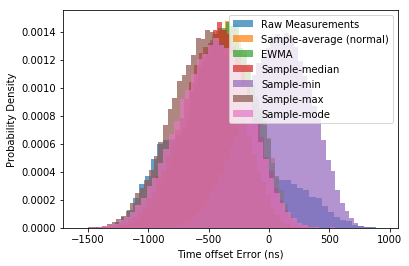

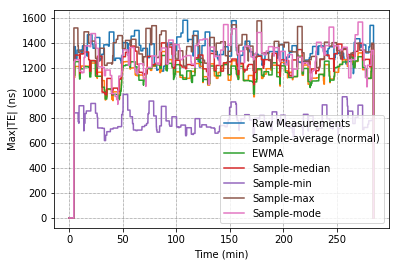

In [6]:
# Optimize window w.r.t to true time offset drift
freq_estimator.optimize_to_drift()
print("Process with delta {:d}".format(freq_estimator.delta))

freq_estimator.process()
freq_estimator.estimate_drift()

# Optimize window length and run all packet selection algorithms
process_all()

# PTP analyser
analyser.toffset_err_stats()
analyser.plot_toffset_err_hist(save=False)
analyser.plot_max_te(save=False, window_len = 1000)

### Drift Optimizer #3

Optimal damping factor: 0.707000
Optimal loop bandwidth: 0.040000
Tunned window lengths:
                  ls: 128
      sample-average: 128
         sample-ewma: 512
       sample-median: 8192
          sample-min: 8192
          sample-max: 8192
         sample-mode: 8192

Time offset estimation error statistics:

x_est                 Mean: -390.795 ns  Sdev:  389.033 ns  RMS:   551.424 ns
x_pkts_avg_normal     Mean: -390.916 ns  Sdev:  137.607 ns  RMS:   414.428 ns
x_pkts_ewma           Mean: -391.469 ns  Sdev:  133.097 ns  RMS:   413.477 ns
x_pkts_median         Mean: -416.278 ns  Sdev:  132.382 ns  RMS:   436.821 ns
x_pkts_min            Mean:  -72.364 ns  Sdev:  134.471 ns  RMS:   152.705 ns
x_pkts_max            Mean: -535.028 ns  Sdev:  137.149 ns  RMS:   552.326 ns
x_pkts_mode           Mean: -346.360 ns  Sdev:  137.339 ns  RMS:   372.595 ns


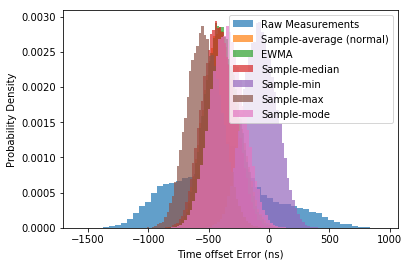

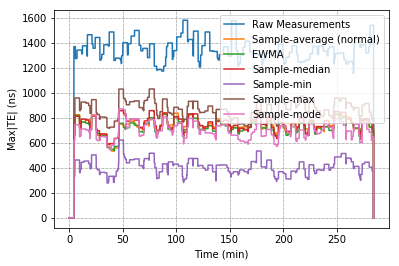

In [7]:
damping, loopbw = freq_estimator.optimize_loop()

print("Optimal damping factor: {:f}".format(damping))
print("Optimal loop bandwidth: {:f}".format(loopbw))

# Estimate drift using PI loop
freq_estimator.loop(damping = damping, loopbw = loopbw)

# Optimize window length and run all packet selection algorithms
process_all()

# PTP analyser
analyser.toffset_err_stats()
analyser.plot_toffset_err_hist(save=False)
analyser.plot_max_te(save=False, window_len = 1000)